In [9]:
import sys
sys.path.insert(0,'..')
import matplotlib.pyplot as plt
import pandas as pd
from doe_xstock.database import SQLiteDatabase

In [10]:
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
DATABASE_FILEPATH = '/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/database.db'
DATABASE = SQLiteDatabase(DATABASE_FILEPATH)

In [27]:
query = f"""
SELECT
    s.metadata_id,
    s.reference,
    l.timestep,
    l.cooling_load/i.cooling_load AS cooling_load_multiplier,
    l.heating_load/i.heating_load AS heating_load_multiplier,
    w.average_indoor_air_temperature AS mechanical_temperature,
    i.average_indoor_air_temperature AS ideal_temperature,
    l.average_indoor_air_temperature AS other_equipment_temperature,
    w.average_indoor_air_temperature - i.average_indoor_air_temperature AS mechanical_ideal_temperature_difference,
    i.average_indoor_air_temperature - l.average_indoor_air_temperature AS ideal_other_equipment_temperature_difference,
    e.cooling_setpoint,
    e.heating_setpoint,
    l.average_indoor_air_temperature - e.cooling_setpoint AS other_equipment_cooling_setpoint_difference,
    l.average_indoor_air_temperature - e.heating_setpoint AS other_equipment_heating_setpoint_difference
FROM lstm_train_data l
LEFT JOIN energyplus_simulation s ON
    s.id = l.simulation_id
LEFT JOIN (SELECT * FROM energyplus_simulation WHERE reference = 0) t ON 
    t.metadata_id = s.metadata_id
LEFT JOIN energyplus_mechanical_system_simulation w ON 
    w.simulation_id = t.id AND w.timestep = l.timestep
LEFT JOIN (SELECT * FROM energyplus_simulation WHERE reference = 1) h ON 
    h.metadata_id = s.metadata_id
LEFT JOIN energyplus_ideal_system_simulation i ON 
    i.simulation_id = h.id AND i.timestep = l.timestep
LEFT JOIN (
    SELECT
        *,      
        ROW_NUMBER() OVER(PARTITION BY building_id ORDER BY timestamp ASC) AS timestep
    FROM ecobee_timeseries
) e ON e.timestep = l.timestep AND e.building_id = t.ecobee_building_id
;
"""
data = DATABASE.query_table(query)

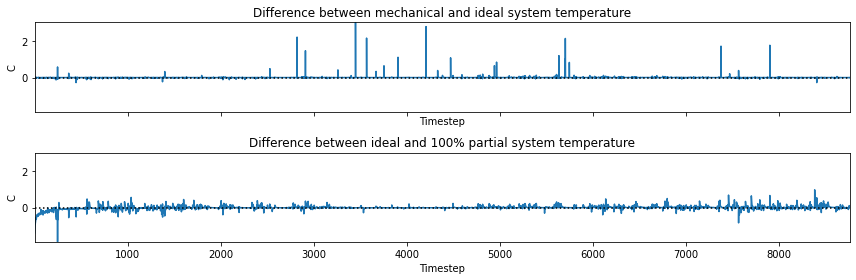

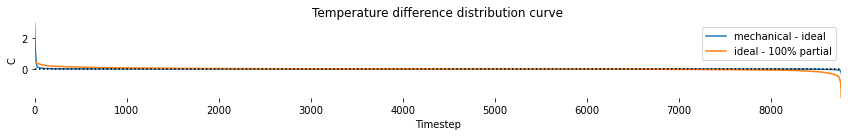

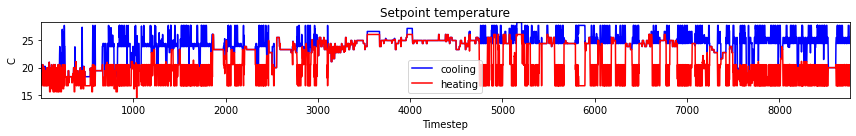

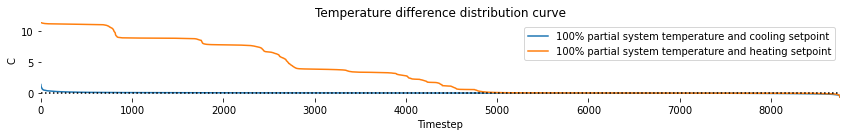

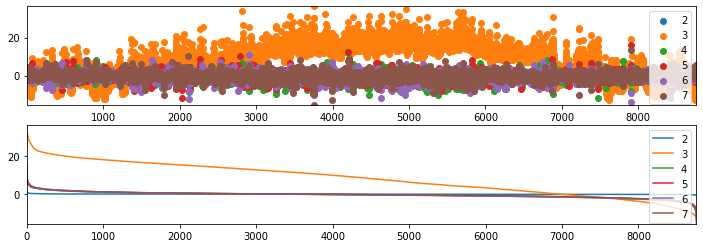

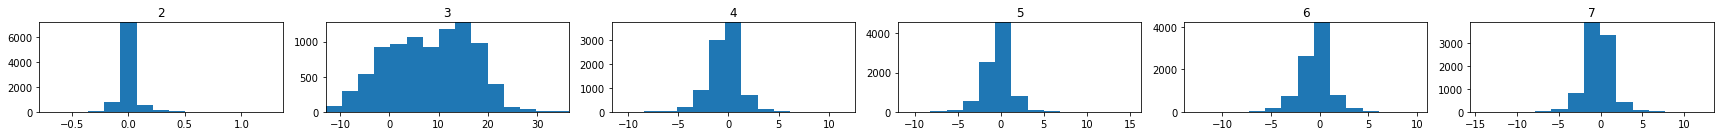

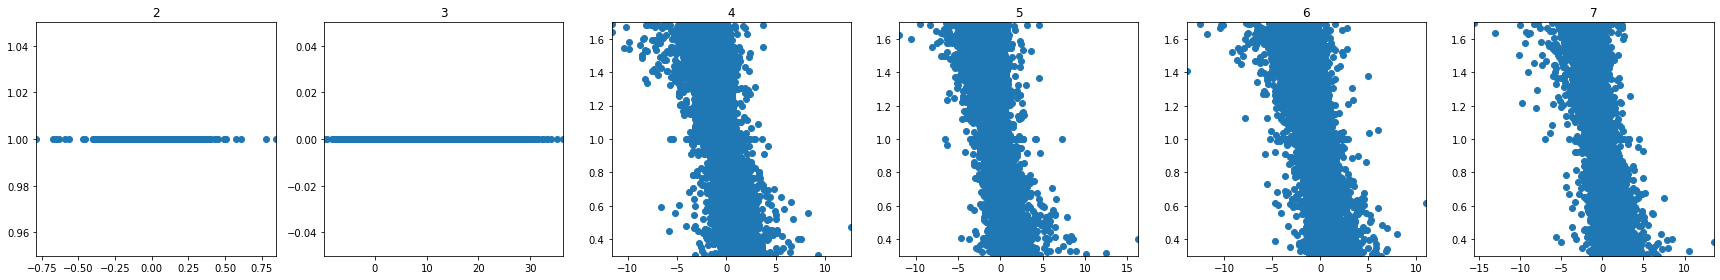

In [29]:
# temperature difference time series
row_count, column_count = 2, 1
fig, axs = plt.subplots(row_count, column_count, figsize=(12*column_count,2*row_count), sharex=True, sharey=True)
plot_data = data[data['reference']==2].copy()
x, y1, y2 = plot_data['timestep'], plot_data['mechanical_ideal_temperature_difference'], plot_data['ideal_other_equipment_temperature_difference']
axs[0].plot(x,y1)
axs[1].plot(x,y2)
axs[0].set_title('Difference between mechanical and ideal system temperature')
axs[1].set_title('Difference between ideal and 100% partial system temperature')

for ax in fig.axes:
    ax.axhline(0, color='black', linestyle=':')
    ax.set_xlabel('Timestep')
    ax.set_ylabel('C')

plt.tight_layout()
plt.show()

# temperature difference duration curve
row_count, column_count = 1, 1
fig, ax = plt.subplots(row_count, column_count, figsize=(12,2))
y1 = plot_data.sort_values(
    'mechanical_ideal_temperature_difference', ascending=False
)['mechanical_ideal_temperature_difference'].tolist()
y2 = plot_data.sort_values(
    'ideal_other_equipment_temperature_difference', ascending=False
)['ideal_other_equipment_temperature_difference'].tolist()
ax.plot(y1, label='mechanical - ideal')
ax.plot(y2, label='ideal - 100% partial')
ax.set_xlabel('Timestep')
ax.set_ylabel('C')
ax.axhline(0, color='black', linestyle=':')
ax.spines[['right','top','left','bottom']].set_visible(False)
ax.set_title('Temperature difference distribution curve')
ax.legend()
plt.tight_layout()
plt.show()

# setpoint time series
row_count, column_count = 1, 1
fig, ax = plt.subplots(row_count, column_count, figsize=(12,2))

x, y1, y2, y3 = plot_data['timestep'], plot_data['cooling_setpoint'], plot_data['heating_setpoint'], plot_data['other_equipment_temperature']
ax.plot(x, y1, color='blue', label='cooling')
ax.plot(x, y2, color='red', label='heating')
# ax.plot(x, y3, color='black', label='temperature')
ax.set_xlabel('Timestep')
ax.set_ylabel('C')
ax.set_title('Setpoint temperature')
ax.legend()
plt.tight_layout()
plt.show()

# # temperature-setpoint difference time series
# row_count, column_count = 2, 1
# fig, axs = plt.subplots(row_count, column_count, figsize=(12*column_count,2*row_count), sharex=True, sharey=True)
# plot_data = data[data['reference']==2].copy()
# x, y1, y2 = plot_data['timestep'], plot_data['other_equipment_cooling_setpoint_difference'], plot_data['other_equipment_heating_setpoint_difference']
# axs[0].plot(x,y1)
# axs[1].plot(x,y2)
# axs[0].set_title('Difference between 100% partial system temperature and cooling setpoint')
# axs[1].set_title('Difference between 100% partial system temperature and heating setpoint')

# for ax in fig.axes:
#     ax.axhline(0, color='black', linestyle=':')
#     ax.set_xlabel('Timestep')
#     ax.set_ylabel('C')

# plt.tight_layout()
# plt.show()

# temperature-setpoint difference duration curve
row_count, column_count = 1, 1
fig, ax = plt.subplots(row_count, column_count, figsize=(12,2))
y1 = plot_data.sort_values(
    'other_equipment_cooling_setpoint_difference', ascending=False
)['other_equipment_cooling_setpoint_difference'].tolist()
y2 = plot_data.sort_values(
    'other_equipment_heating_setpoint_difference', ascending=False
)['other_equipment_heating_setpoint_difference'].tolist()
ax.plot(y1, label='100% partial system temperature and cooling setpoint')
ax.plot(y2, label='100% partial system temperature and heating setpoint')
ax.set_xlabel('Timestep')
ax.set_ylabel('C')
ax.axhline(0, color='black', linestyle=':')
ax.spines[['right','top','left','bottom']].set_visible(False)
ax.set_title('Temperature difference distribution curve')
ax.legend()
plt.tight_layout()
plt.show()

# temperature difference duration curve between partial load setpoint and cooling setpoint
row_count = 2
column_count = 1
fig, axs = plt.subplots(row_count, column_count, figsize=(12,2*row_count))

for r, r_data in data[data['reference']>=2].groupby('reference'):
    x, y1 = r_data['timestep'], r_data['other_equipment_cooling_setpoint_difference']
    y2 = r_data.sort_values(
        'other_equipment_cooling_setpoint_difference', ascending=False
    )['other_equipment_cooling_setpoint_difference'].tolist()
    axs[0].scatter(x, y1, label=r)
    axs[1].plot(y2, label=r)

for ax in fig.axes:
    ax.legend()

# temperature difference duration curve between partial load setpoint and cooling setpoint
plot_data = data[data['reference']>=2].copy()
row_count = 1
column_count = len(plot_data['reference'].unique())
fig, axs = plt.subplots(row_count, column_count, figsize=(4*column_count,2*row_count))

for ax, (r, r_data) in zip(fig.axes, plot_data.groupby('reference')):
    y = r_data['other_equipment_cooling_setpoint_difference']
    ax.hist(y, bins=15)
    ax.set_title(r)

plt.tight_layout()
plt.show()

# temperature difference duration curve between partial load setpoint and cooling setpoint
plot_data = data[data['reference']>=4].copy()
row_count = 1
column_count = len(plot_data['reference'].unique())
fig, axs = plt.subplots(row_count, column_count, figsize=(4*column_count,4*row_count))

for ax, (r, r_data) in zip(fig.axes, plot_data.groupby('reference')):
    x = r_data['other_equipment_cooling_setpoint_difference']
    y = r_data['cooling_load_multiplier']
    ax.scatter(x, y)
    ax.set_title(r)

plt.tight_layout()
plt.show()

In [32]:
plot_data[plot_data['other_equipment_cooling_setpoint_difference'].abs()>1.8].groupby('reference').size()

reference
3    7683
4    1804
5    1851
6    1857
7    1751
dtype: int64

In [51]:
columns = [
    'Year',
    'Month',
    'Day',
    'Hour',
    'Minute',
    'Data Source and Uncertainty Flags',
    'Dry Bulb Temperature (C)',
    'Dew Point Temperature (C)',
    'Relative Humidity (%)',
    'Atmospheric Station Pressure (Pa)',
    'Extraterrestrial Horizontal Radiation (Wh/m2)',
    'Extraterrestrial Direct Normal Radiation (Wh/m2)',
    'Horizontal Infrared Radiation Intensity (Wh/m2)',
    'Global Horizontal Radiation (Wh/m2)',
    'Direct Normal Radiation (Wh/m2)',
    'Diffuse Horizontal Radiation (Wh/m2)',
    'Global Horizontal Illuminance (lux)',
    'Direct Normal Illuminance (lux)',
    'Diffuse Horizontal Illuminance (lux)',
    'Zenith Luminance (Cd/m2)',
    'Wind Direction (Degrees)',
    'Wind Speed (m/s)',
    'Total Sky Cover (Tenths of Coverage. 1 is 1/10 coverage. 10 is full coverage)',
    'Opaque Sky Cover (Tenths of Coverage. 1 is 1/10 coverage. 10 is full coverage)',
    'Visibility (km)',
    'Ceiling Height (m)',
    'Present Weather Observation',
    'Present Weather Codes',
    'Precipitable Water (mm)',
    'Aerosol Optical Depth (thousandths)', 'Snow Depth (cm)',
    'Days Since Last Snowfall (Days)', 'Albedo (unit less)',
    'Liquid Precipitation Depth (mm)',
    'Liquid Precipitation Quantity (hr)'
]
df = pd.DataFrame(columns,columns=['variable'])
df['source'] = "\cite{meteostat}"
df.to_latex('table.tex', index=False, escape=False)